**Аналитические оценки обобщающей способности**

In [7]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

Датасет кредитной истории для линейной регрессии. Есть и качественные признаки.

In [4]:
credit = pd.read_csv('Credit.csv', usecols=list(range(1,12)))
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580


**Кодируем качественные признаки**

In [5]:
credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Male,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,333,1,0,1,0,1
1,106.025,6645,483,3,82,15,903,0,1,1,1,0
2,104.593,7075,514,4,71,11,580,1,0,0,1,0


Для выбора наилучшей модели, обучим модели для каждого набора признаков и потом выберем лучший.

In [ ]:
def fit_linear_reg(X,Y):
    #Обучаем линейную регрессию и возвращаем RSS и R^2
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

**Реализуем выбор лучшего набора (thru itertools.combinations)**

In [8]:
#Импортим tqdm для прогрессбара
from tqdm import tnrange, tqdm_notebook

#инит
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Итерируем от 1 до 11 признаков в X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Итерируем по всем возможным комбинациям, из 11 берём k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Храним промежуточный 
        RSS_list.append(tmp_result[0]) #соединяем списки
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#храним в датафрейме
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

Находим лучшие наборы для каждого кол-ва признаков

In [9]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
12,2,1.053254e+07,0.875118,"(Income, Rating)"
79,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"


,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
12,2,1.053254e+07,0.875118,"(Income, Rating)"
79,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"


Добавляем столбцы в датафрейм с RSS и R2 для лучшего набора

In [10]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,6.620874e+07,0.214977,"(Income,)",2.143512e+07,0.745848
1,1,2.171566e+07,0.742522,"(Limit,)",2.143512e+07,0.745848
2,1,2.143512e+07,0.745848,"(Rating,)",2.143512e+07,0.745848
3,1,8.370950e+07,0.007475,"(Cards,)",2.143512e+07,0.745848
4,1,8.433963e+07,0.000003,"(Age,)",2.143512e+07,0.745848


**Графики процесса выбора лучших наборов**

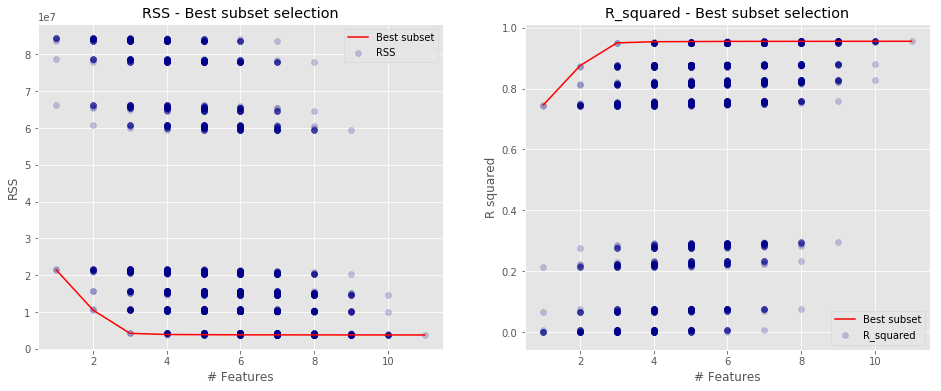

In [11]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

**Пошаговое добавление признаков**

In [13]:
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf]
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)    
            #Храним временный результат
            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Обновляем переменные для некст итерации
    features.append(best_feature)
    remaining_features.remove(best_feature)
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122.0),
 (2, ['Rating', 'Income'], 10532541.0),
 (3, ['Rating', 'Income', 'Student_Yes'], 4227219.0),
 (4, ['Rating', 'Income', 'Student_Yes', 'Limit'], 4032502.0)]

**AIC, BIC, Mallow's CP**

Mallow's CP

$$C_p=\frac{1}{m}(RSS+2d \hat{\sigma}^2 )$$, где 

AIC - оценивающий модели с разным числом параметров. Критерий связан с понятием расстояния Кульбака — Лейблера, при помощи которого можно оценить расстояние между моделями. AIC = $2K+n\[\ln(\hat{\sigma}^2)\]$ 
$$ SSE=\|f(x_i)-y_i\|_2=\sum_{i=1}^N(y_i-f(w,x_i))^2;$$

$\hat{\sigma}^2=\frac{SSE}{N-2}$ — дисперсия остатков;
Лучшая модель соответствует минимальному значению критерия Акаике. Абсолютное значение критерия не несет в себе полезной информации.

BIC

Выпишем через SSE (Sum of Squared Errors) - сумму квадратов остатков:
$$BIC=n\ln\frac{SSE}{n}+k\ln n.$$
В данном случае логарифмируется смещенная оценка дисперсии регрессионных остатков.



Подогнанный $R^2$

Т.к. $R^2$ всегда увелчивается по мере роста кол-ва переменных, данная версия включает штраф. Помогает справляться с шумами (новыми переменными, которые даже не сильно уменьшают RSS), т.е, платим цену за включение ненужных переменных в модели.

$$R^2_a= 1-\frac{RSS/(m−k−1)}{TSS/(m−1)}= 1 − (1−R^2)\frac{m−1}{m−k−1}$$

In [14]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [15]:
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Считаем оценки
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Rating],2.143512e+07,0.745848,1,53636.603151,5.495771,5.505750,0.745210
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.949364,2.707991,2.727949,0.874489
3,"[Rating, Income, Student_Yes]",4.227219e+06,0.949879,3,10714.442485,1.097835,1.127771,0.949499
4,"[Rating, Income, Student_Yes, Limit]",4.032502e+06,0.952188,4,10276.446437,1.052956,1.092871,0.951703
5,"[Rating, Income, Student_Yes, Limit, Cards]",3.866091e+06,0.954161,5,9909.218362,1.015329,1.065222,0.953579
6,"[Rating, Income, Student_Yes, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.837591,1.008937,1.068809,0.953996
7,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.810759e+06,0.954817,7,9868.483418,1.011155,1.081006,0.954010
8,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.804746e+06,0.954888,8,9902.248962,1.014615,1.094444,0.953965
9,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.798367e+06,0.954964,9,9935.100415,1.017981,1.107789,0.953924
10,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.791345e+06,0.955047,10,9966.344067,1.021182,1.120969,0.953891


In [16]:
df1['R_squared_adj'].idxmax()
df1['R_squared_adj'].max()

0.9540098163629882

Строим полученные значения как функцию от кол-ва признаков

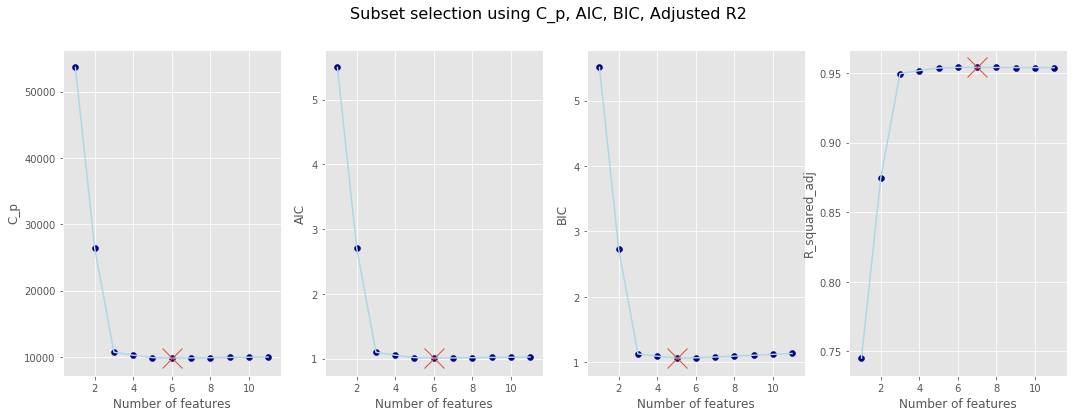

In [18]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of features')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()